# Example Generating and Analyzing GW190521-like Signal

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Important to set this before you execute any jax code, so it goes before the other imports
import numpyro
numpyro.set_host_device_count(10) # Or however many cores you have

import arviz as az
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ringdown as rd
import scri

/Users/wfarr/Research/ModeDetectability/.venv/lib/python3.13/site-packages/ringdown/data.py:10: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


## First, load the PE samples and the noise PSD inferred for GW190521.

In [3]:
with h5py.File('../data/GW190521_posterior_samples.h5', 'r') as f:
    samples = pd.DataFrame(f['NRSur7dq4/posterior_samples'][:])

In [4]:
psds = {}
with h5py.File('../data/GW190521_posterior_samples.h5', 'r') as f:
    for ifo in f['NRSur7dq4/psds'].keys():
        psds[ifo] = pd.DataFrame(f['NRSur7dq4/psds/' + ifo][:], columns=['f', 'psd'])

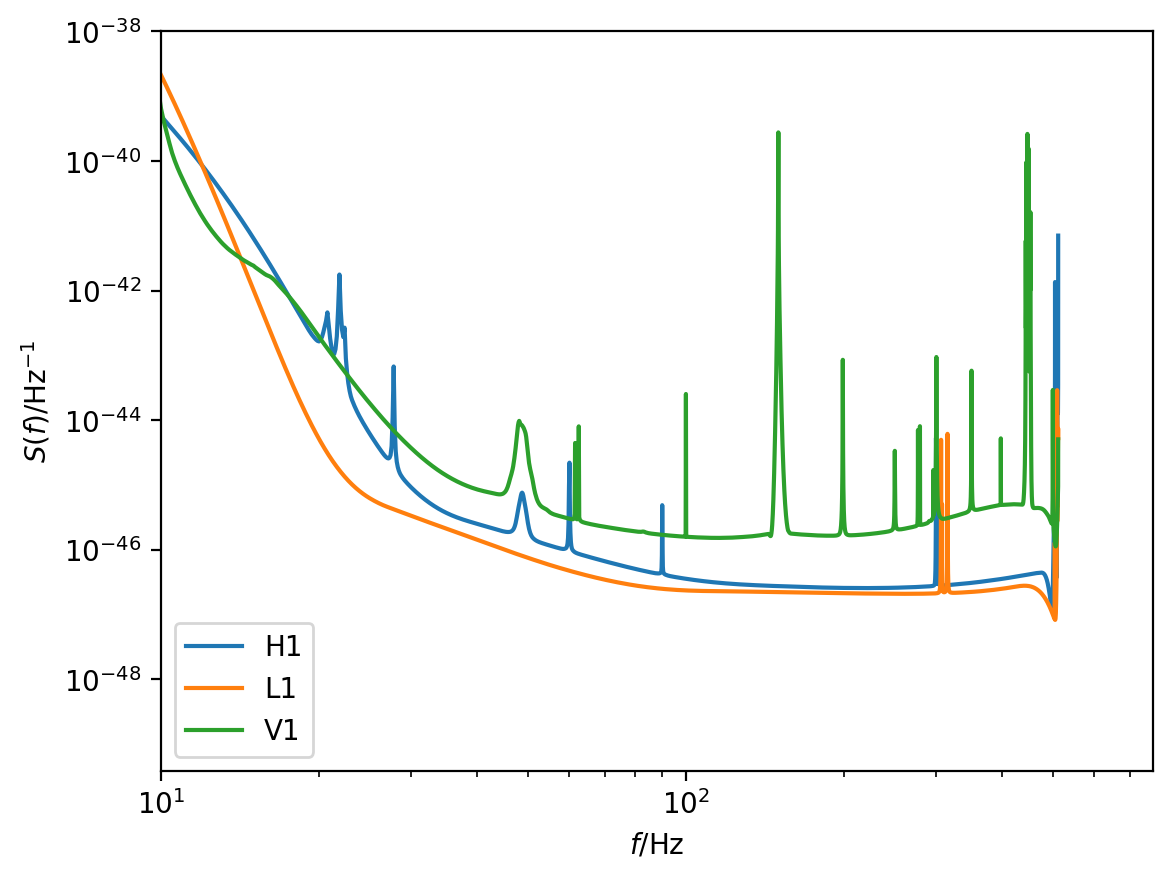

In [5]:
for k,v in psds.items():
    plt.plot(psds[k]['f'], psds[k]['psd'], label=k)
plt.yscale('log')
plt.xscale('log')
plt.ylim(None, 1e-38)
plt.xlim(10, None)
plt.xlabel(r'$f / \mathrm{Hz}$')
plt.ylabel(r'$S(f) / \mathrm{Hz}^{-1}$')
plt.legend()

## Now Load the Ringdown Surrogate Data

This predicts amplitudes of the various ringdown modes at $10 M$ for a random system.  Eventually we will improve this to use the PE samples from above for the event GW190521 (which is public); for now, let's just use the PSDs to get a reasonable estimate of the LIGO noise.

Keefe generated this ringdown fit, and it has at least the following mode amplitudes in it:
```
[((2, -2, 0, -1), 0.4334839900403974),
 ((2, 2, 0, 1), 0.42497463587470796),
 ((2, -2, 1, -1), 0.33495136439774803),
 ((2, 2, 1, 1), 0.3265663228700879),
 ((2, 1, 1, 1), 0.03307319493376208),
 ((3, 3, 1, 1), 0.030079922297295874),
 ((2, -1, 0, -1), 0.02899586107332202),
 ([(2, -2, 0, -1), (2, -2, 0, -1)], 0.025287397413406135),
 ((3, 3, 0, 1), 0.02064874435766127),
 ([(2, 2, 0, 1), (2, 2, 0, 1)], 0.02060452357012178),
]
```

His convention lists the modes as `(l, m, n, s)` where the mode is prograde if `sign(m*s) = 1` and retrograde otherwise.  The mode amplitudes are in arbitrary units at $10 M$.  If two mode indices are given, then the mode is actually the non-linear mixing of the given linear modes.  So you can see that the largest amplitudes are the prograde $\ell = 2$, $m = \pm 2$ modes, and then the next is the prograde $\ell = 2$, $m = \pm 1$ modes, and the rest are at least an order of magnitude smaller.  We want to fit this synthetic signal at various SNRs to determine when the $m = \pm 1$ modes are (1) necessary to get a consistent final mass and spin and (2) required to get a good fit to the data (not considering consistency of the final mass and spin).

In [6]:
m_final_event = 283.159208
chi_final_event = 0.687620
t_m = rd.qnms.T_MSUN * m_final_event
h_event = scri.SpEC.read_from_h5('../data/rhOverM_ringdown_QNMs.h5')

The above is a unitless waveform, with time in units of $t_M$, stored over the entire "celestial sphere."  You can get the h-plus and h-cross components by evaluating it at a particular location on the sky (here $\theta$ is the colatitude, or inclination; $\phi$ is the azimuth, or phase).  The result is a complex array storing both polarizations:
$$
h = h_+ - i h_\times
$$

In [7]:
random_theta = np.arccos(np.random.uniform(-1,1))
random_phi = np.random.uniform(0, 2*np.pi)
one_h = h_event.to_sxs.evaluate(random_theta, random_phi)

Let's plot it:

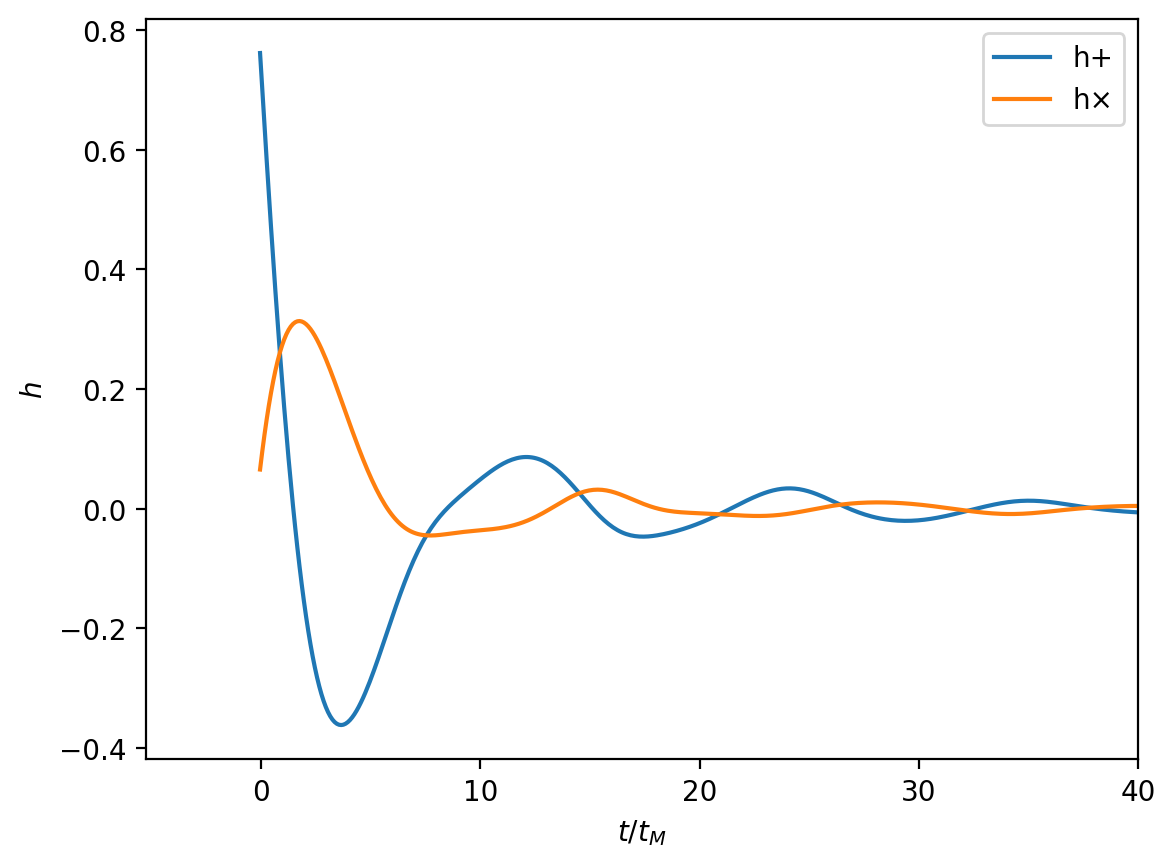

In [8]:
plt.plot(one_h.time, np.real(one_h), label='h+')
plt.plot(one_h.time, -np.imag(one_h), label='h×')

plt.xlabel(r'$t / t_M$')
plt.ylabel(r'$h$')

plt.xlim(None, 40)
plt.legend()

## Example Fit, Putting Everything Together

First, we note that the analysis sample rate above is 1024 Hz (because the PSD stops just above 500 Hz, and we know that we prefer powers-of-two, we infer a Nyquist frequency of 512 Hz, or a 1024 Hz sample rate).  We will interpolate the waveform to that sample rate, and evaluate it to get the intrinsic $h_+$ and $h_\times$ as a function of the time after merger.

In [9]:
srate = 1024 # Hz
dt = 1/srate

time_axis = dt * (np.arange(srate) - 10) # One full second of data, with 10 samples before the peak time, and the remainder after
time_axis_in_M = time_axis / t_m

h_complex_raw = h_event.to_sxs.evaluate(random_theta, random_phi)
h_complex = np.interp(time_axis_in_M, h_complex_raw.time, h_complex_raw.data)
h_plus_unitless = np.array(np.real(h_complex)) # np.array strips off all the time information, since we have computed it above
h_cross_unitless = -np.array(np.imag(h_complex))

scale_factor = 2.5e-20 # This will put the SNR close to 20 from 10M onward
h_plus = h_plus_unitless * scale_factor
h_cross = h_cross_unitless * scale_factor

Now we make a fit object to fit this with the $220$ and $210$ prograde modes (recall that `ringdown` wants the mode labels to be in $(p, s, \ell, m, n)$, where $p$ is $\pm 1$ for prograde/retrograde, $s$ is the spin weight of the mode, always -2 for tensor modes like this, and $\ell$, $m$, and $n$ are the angular and overtone quantum numbers):

In [10]:
fit = rd.Fit(modes=[(1, -2, 2, 2, 0), (1, -2, 2, 1, 0)])

Let's grab a random sample from GW190521 to obtain a sky location, and thus a delay time between arrival at various detectors:

In [11]:
random_pe = samples.iloc[np.random.randint(len(samples))]
dt_in_m = 10.0 # For now, we want to fit from 10 t_m onward
t0_geocent = 0
psi_angle = 0
fit.set_target(t0_geocent + dt_in_m*t_m, random_pe['ra'], random_pe['dec'], psi_angle, duration=0.5)

Now we add the data and the associated ACF; the "patching" process makes the PSD very large (but not *too* large) below 10 Hz and above 90% of the Nyquist frequency, as a way of making the fit *ignore* the data in these frequency ranges.

In [12]:
for ifo in ['H1', 'L1', 'V1']:
    time_shift = rd.get_delay(ifo, t0_geocent, random_pe['ra'], random_pe['dec'])
    Fp, Fc = fit.target.get_antenna_patterns(ifo)

    psd = rd.PowerSpectrum(psds[ifo]['psd'], delta_f=np.diff(psds[ifo]['f'])[0])

    patch_low = 10 # Hz
    patch_high = int(round(srate/2 * 0.9)) # Hz; 90% of the Nyquist frequency
    patch_level = 1e-38 # Chosen by hand to be big!
    psd = psd.patch(patch_low, patch_high, patch_level)

    noise_psd = rd.PowerSpectrum(np.zeros_like(psd), delta_f=np.diff(psds[ifo]['f'])[0]) # Don't put noise in the patch
    noise_psd.loc[(psd.index > patch_low) & (psd.index < patch_high)] = psd.loc[(psd.index > patch_low) & (psd.index < patch_high)]

    noise = noise_psd.draw_noise_td(duration=10*len(h_plus)*dt, f_samp=srate)
    No2 = noise.shape[0] // 2
    noise = np.array(noise.iloc[No2:No2+len(h_plus)])  # Make sure noise is the same length as the time axis, drawing from the middle in case the array is windowed

    fit.add_data(Fp * h_plus + Fc * h_cross + noise, time = time_shift+time_axis, ifo=ifo, acf=psd.to_acf())

/Users/wfarr/Research/ModeDetectability/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/wfarr/Research/ModeDetectability/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/wfarr/Research/ModeDetectability/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Just to make sure we are sane, let's plot the PSDs we have; you can see the patching:

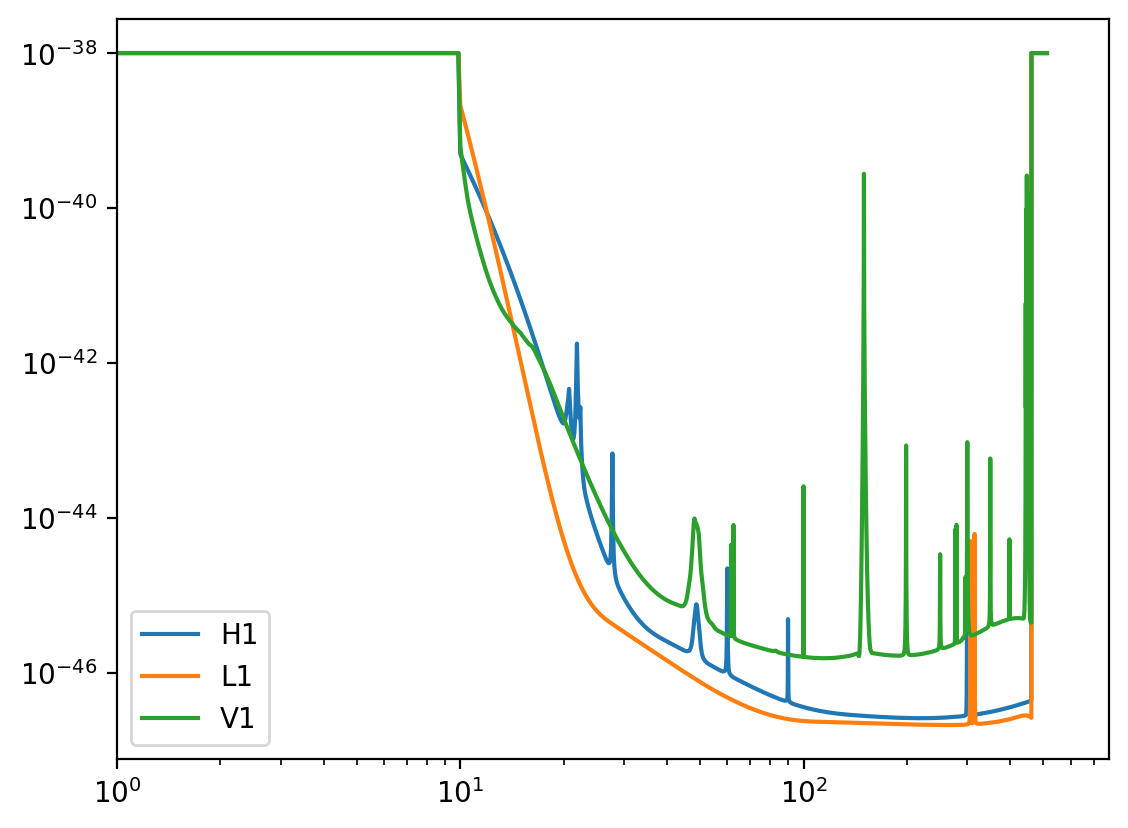

In [13]:
for ifo in fit.ifos:
    fit.acfs[ifo].to_psd().plot(label=ifo)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, None)
plt.legend()

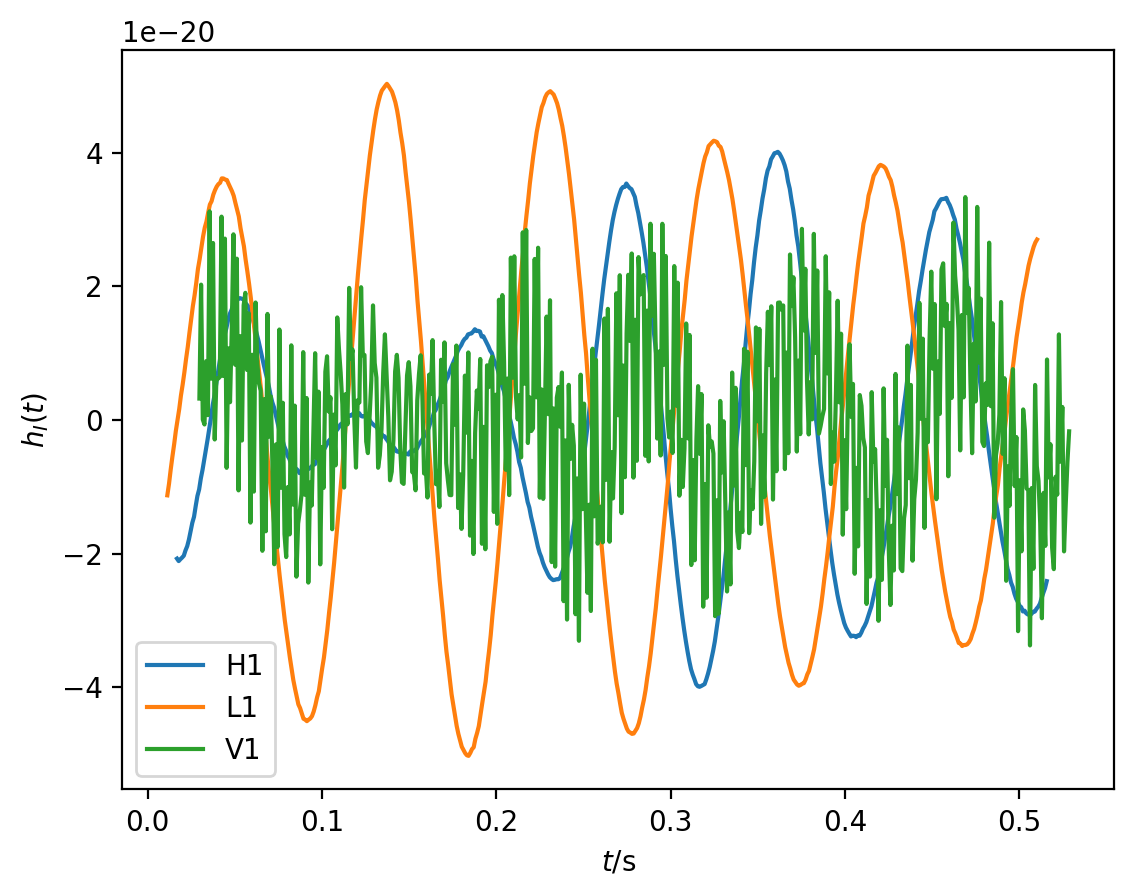

In [14]:
for ifo in fit.ifos:
    fit.analysis_data[ifo].plot(label=ifo)
plt.xlabel(r'$t / \mathrm{s}$')
plt.ylabel(r'$h_I(t)$')
plt.legend()

Set up the prior (remember that `a_scale_max` should be much larger, at least a factor of 10, than any amplitude we expect in the data; I set it really high here, because I wanted room to grow if you adjust the scale factor to higher SNRs).

In [15]:
fit.update_model(a_scale_max=1e-19, m_min=m_final_event/2, m_max=2*m_final_event)

Just for fun, you can look at the data, and see the oscillations of the mode against the noise pretty clearly (change the IFO argument to see the other detectors):

<Axes: >

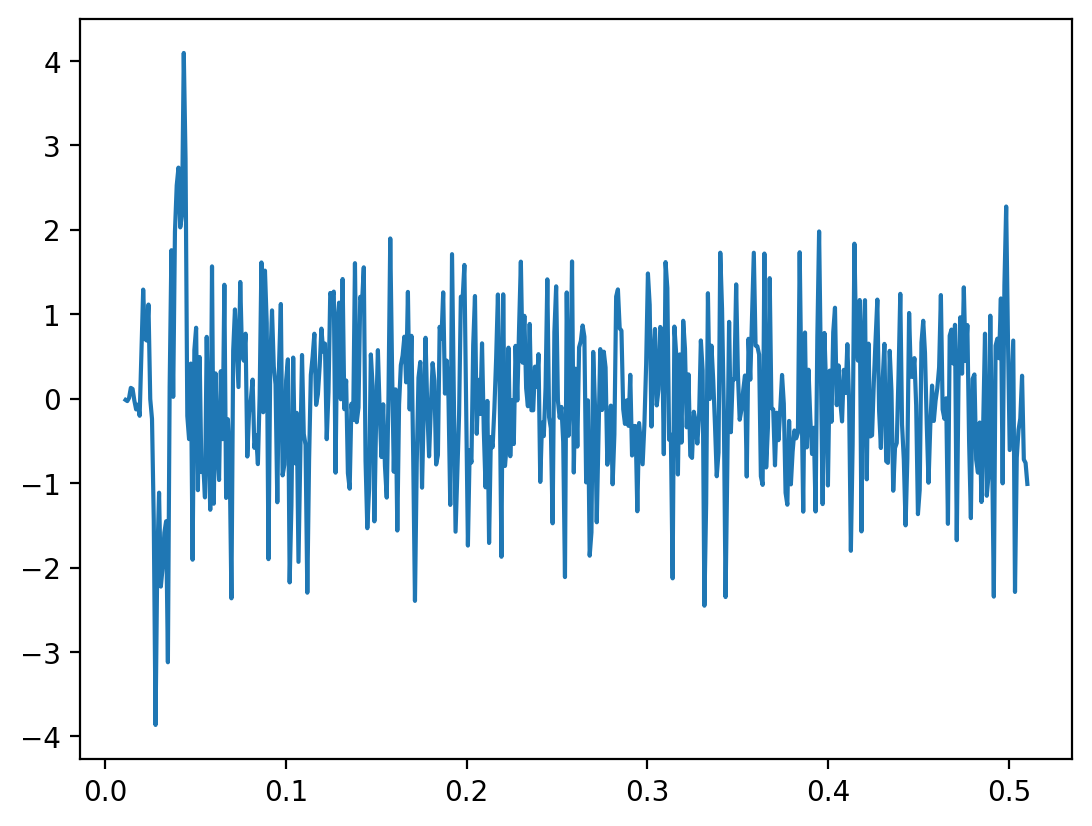

In [16]:
i = 'L1'
fit.acfs[i].iloc[:fit.analysis_data[i].shape[0]].whiten(fit.analysis_data[i]).plot()

Now let's fit:

In [17]:
fit.run()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

array([[<Axes: title={'center': 'm'}>, <Axes: title={'center': 'm'}>],
       [<Axes: title={'center': 'chi'}>, <Axes: title={'center': 'chi'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'f'}>, <Axes: title={'center': 'f'}>],
       [<Axes: title={'center': 'g'}>, <Axes: title={'center': 'g'}>]],
      dtype=object)

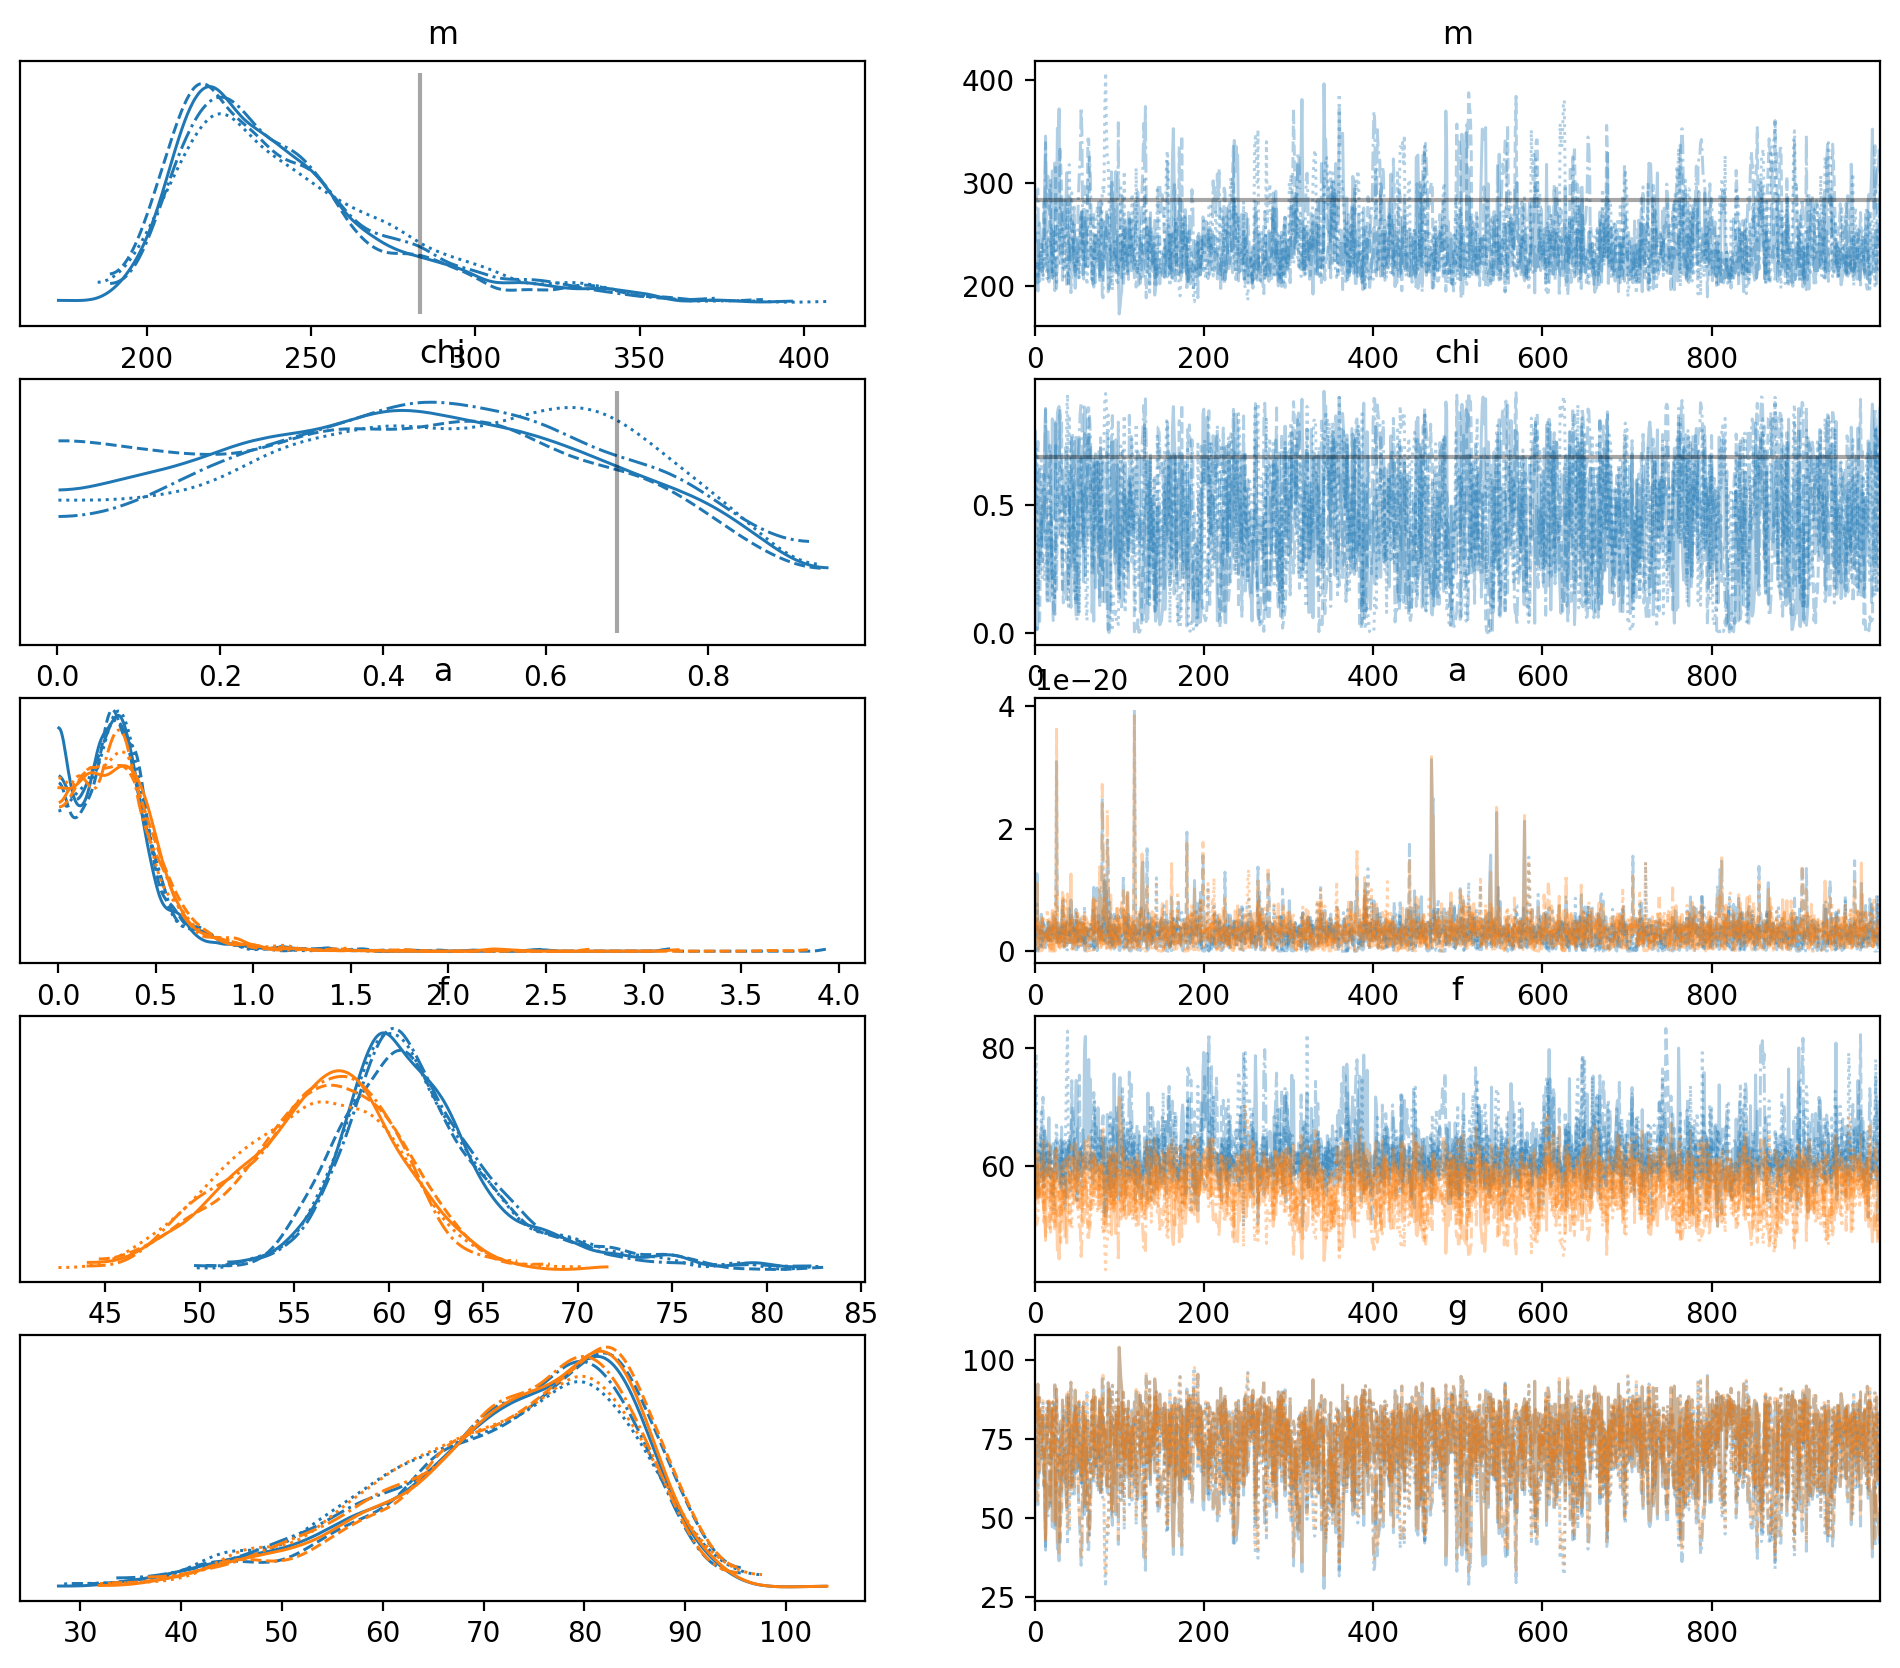

In [18]:
az.plot_trace(fit.result, var_names=['m', 'chi', 'a', 'f', 'g'], lines=[('m', {}, m_final_event), ('chi', {}, chi_final_event)])

From here, TODO:

1. Try the fit for waveforms generated at different sky locations (`random_theta` and `random_phi`).
1. Try the fit at different SNRs by re-scaling the waveform (SNR 20, 40, 80, 160, say?).
1. Try fitting the 220 mode alone and check IMR consistency.
1. Try fitting an overtone (220+221) and check IMR consistency / detectability.
1. Try fitting *other* modes that *aren't* present, like, say, the 200 mode, and see if the fits are IMR consistent?
1. Probably more, but this is already a lot.